# Bayes' theorem

Bayesheorem is a formala that describes how to update the probabilities of hypotheses when given evidence.

Given a hypothesis $\theta$ and evidence $x$, Bayes' theorem states that the relationship between the propability of the hypothesis before getting the evidence $P(\theta)$ and the probability of hypothesis after getting the evidence $P(\theta | x)$ is:

\begin{equation}
P(\theta|x)=\frac{P(\theta \cap x)}{P(x)}=\frac{P(x|\theta)· P(\theta)}{P(x)}
\end{equation}

Here we use $P(x|\theta)$ as the likelihood, $P(\theta)$ is the prior, that is the probability that appear $\theta$ in the model and $P(x)$ is the evidence, the probobility of observing the datas given the true model.

In [67]:
#librerias a usar 
import matplotlib. pyplot as plt
import numpy as np
import random
import scipy
import scipy.special
import math
from scipy.optimize import minimize
import scipy.optimize as op
import scipy.stats as stats
import time
%matplotlib inline

Arrangement of the data to work with them:

In [15]:
#datos:
tb1=np.loadtxt('jla_mub_covmatrix.dat')
tb2=np.loadtxt('jla_mub.txt')

# divido los datos de jla_mub.txt en dos arrelgos z y mu 
z=tb2[:,0]
mu=tb2[:,1]

In [16]:
#arreglo los datos de jla_mud_covmatrix.dat en una matriz de 31x31
covmatrix=[]
for i in range(31):
    row=[]
    for j in range(31):
        row.append(tb1[(31*i)+j])
    covmatrix.append(row)

In [17]:
#Pongo las varianzas de la matriz anterior (que se encuentran en la diagunal) en un arreglo.  
var=[]
for i in range(31):
    var.append(covmatrix[i][i])

### Equations:

In [18]:
def sss(omg):
    return pow((1-omg)/omg,(1/3))

In [19]:
def eta(a,omg):
    r=np.sqrt(pow(sss(omg),3)+1)
    return 2*r*pow((pow(a,-4)-(0.1540*sss(omg)*pow(a,-3))+(0.4304*pow(sss(omg),2)*pow(a,-2))+(0.19097*pow(sss(omg),3)*pow(a,-1))+(0.066941*pow(sss(omg),4))),-1/8)

In [20]:
def D_L(z,omg,H):
    return (299792.458/H)*(1+z)*(eta(1,omg)-eta((1/(1+z)),omg))

In [21]:
def mud(z,omg,H):
    return 25+(5*np.log10(D_L(z,omg,H)))-(5*np.log10(H/100))

### Function for the maximum likelihood estimation

In [91]:
def lnlik (theta,z,mu,var):
    #Parametrso iniciales
    H0,omg0,lnf= theta
    model=mud(z,omg0,H0)
    inv_sigma2=1.0/(var+(model**2*np.exp(2*lnf)))
    return -0.5*np.sum(pow((mu-model),2)*inv_sigma2 - np.log(inv_sigma2))

In [125]:
H_ini,omg_ini,lnf_ini=50,0.5,5
nll = lambda *args: -lnlik(*args)
result = op.minimize(nll, [H_ini,omg_ini,lnf_ini], args=(z,mu,var))
result
#H_ml,omh_ml=result["x"]

      fun: 3.223552439704793
 hess_inv: array([[2.23620466e+01, 0.00000000e+00, 2.82261632e-02],
       [0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       [2.82261632e-02, 0.00000000e+00, 1.64019815e-02]])
      jac: array([-2.68220901e-06,  0.00000000e+00,  9.11951065e-06])
  message: 'Optimization terminated successfully.'
     nfev: 145
      nit: 17
     njev: 29
   status: 0
  success: True
        x: array([172.43008489,   0.5       ,  -4.05945916])

Marginalization & uncertainty estimation

In [126]:
def lnprior(theta):
    H,omg,lnf=theta
    if 0 < H < 1 and 50 < omg < 100 and -10.0 < lnf < 1.0 :
        return 0.0
    return -np.inf

In [127]:
def lnprob(theta,x,mu,var):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlik(theta,z,mu,var)

In [134]:
ndim, nwalkers = 3, 100
pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

In [140]:
pos

[array([172.87079066,   1.26471682,  -5.30552777]),
 array([ 1.72858745e+02, -1.04710941e-01, -2.69969700e+00]),
 array([171.59714491,   0.40999811,  -5.60334977]),
 array([171.67507915,   1.46914637,  -5.40833124]),
 array([171.14920804,  -0.34276325,  -4.8510218 ]),
 array([171.99113951,   3.04905537,  -3.98840497]),
 array([173.60031613,  -1.37751256,  -3.6214264 ]),
 array([172.42077541,   0.88378404,  -4.40499885]),
 array([172.57830873,   2.51616287,  -3.54063161]),
 array([172.40153471,  -0.38359815,  -5.03424276]),
 array([170.80111118,   0.34613367,  -5.29019017]),
 array([172.89827499,   0.55719885,  -3.32506785]),
 array([ 1.73222148e+02,  1.05085681e-01, -3.09222296e+00]),
 array([ 1.72244019e+02,  1.67535437e-01, -2.98229860e+00]),
 array([ 1.72389294e+02,  1.16733599e-01, -4.26939439e+00]),
 array([172.49568343,   0.33244563,  -4.49621022]),
 array([171.89364505,  -0.78129494,  -6.41030563]),
 array([172.04887429,  -0.33731598,  -5.17782518]),
 array([172.64392237,  -1.95

In [136]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob , args=(z,mu,var))

In [137]:
sampler.run_mcmc(pos,500)

(array([[ 1.72870791e+02,  1.26471682e+00, -5.30552777e+00],
        [ 1.72858745e+02, -1.04710941e-01, -2.69969700e+00],
        [ 1.71597145e+02,  4.09998106e-01, -5.60334977e+00],
        [ 1.71675079e+02,  1.46914637e+00, -5.40833124e+00],
        [ 1.71149208e+02, -3.42763250e-01, -4.85102180e+00],
        [ 1.71991140e+02,  3.04905537e+00, -3.98840497e+00],
        [ 1.73600316e+02, -1.37751256e+00, -3.62142640e+00],
        [ 1.72420775e+02,  8.83784042e-01, -4.40499885e+00],
        [ 1.72578309e+02,  2.51616287e+00, -3.54063161e+00],
        [ 1.72401535e+02, -3.83598152e-01, -5.03424276e+00],
        [ 1.70801111e+02,  3.46133667e-01, -5.29019017e+00],
        [ 1.72898275e+02,  5.57198847e-01, -3.32506785e+00],
        [ 1.73222148e+02,  1.05085681e-01, -3.09222296e+00],
        [ 1.72244019e+02,  1.67535437e-01, -2.98229860e+00],
        [ 1.72389294e+02,  1.16733599e-01, -4.26939439e+00],
        [ 1.72495683e+02,  3.32445630e-01, -4.49621022e+00],
        [ 1.71893645e+02

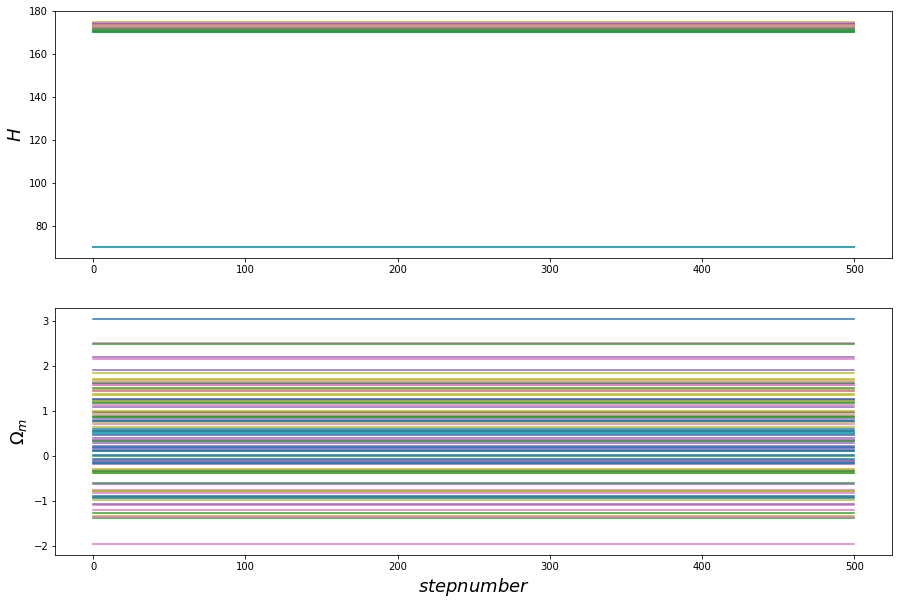

In [138]:
x_g = np.linspace(0.0, 500, 500)
y_H = 70*np.ones(500)
y_omg = 0.5*np.ones(500)
plt.figure(figsize=(15,10))
for i in range(nwalkers):
    plt.subplot(2, 1, 1)
    plt.plot(x_g, sampler.chain[i,:,0], '-')
    plt.plot(x_g, y_H, '-')
    plt.ylabel('$H$',fontsize = 18)

    plt.subplot(2, 1, 2)
    plt.plot(x_g, sampler.chain[i,:,1], '-')
    plt.plot(x_g, y_omg, '-')
    plt.ylabel('$\Omega_m$',fontsize = 18)
    plt.xlabel('$stepnumber$',fontsize = 18)
plt.show()
